In [3]:
# IMPORTS:
import yfinance as yf
import pandas as pd 
from math import sqrt
from scipy.stats import t 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Task 1: CORRELATION ANALYSIS
### 1.1 Collecting historical data for NASDAQ and NSE indices:

In [4]:
class Index:
    
    list_of_indices = []
    index_tickers = []

    
    def __init__(self, ticker):
        self.ticker = ticker
        self.start_date = "2010-01-04"
        self.end_date = "2023-05-01"
        self.period = '1d'
        self.data = self.fetch_data()
        
        # OLHC DATA:
        self.open = self.data['Open']
        self.close = self.data['Close']
        self.high = self.data['High']
        self.low = self.data['Low']
        
        # Creating list of indices using instances: 
        Index.list_of_indices.append(self)
        
        # Creating list of indices tickers using instances: 
        Index.index_tickers.append(self.ticker)
        
    def fetch_data(self):
        return yf.download(self.ticker, start=self.start_date, end=self.end_date, period=self.period, progress=False)
        
        

# Defining instance of Index for each international index: 
nasdaq = Index("^IXIC")
nsei = Index("^NSEI")

Before starting anything let's inspect the number of trading days for NASDAQ Composite and NIFTY50 and take the common days. 

In [5]:
x = pd.DataFrame(nsei.close)
y = pd.DataFrame(nasdaq.close)

In [6]:
x.shape, y.shape

((3268, 1), (3353, 1))

Selecting only the common trading days for finding correlation:

In [7]:
common_trading_days = nasdaq.data.index.intersection(nsei.data.index)

nas = nasdaq.close.loc[common_trading_days]
nse = nsei.close.loc[common_trading_days]

In [8]:
nas.shape, nse.shape

((3182,), (3182,))

### 1.2 Calculate the correlation coefficient between the two indices:

The correlation coefficient is a statistical measure of the strength of a linear relationship between two variables. Its values can range from -1 to 1. A correlation coefficient of -1 describes a perfect negative, or inverse, correlation, with values in one series rising as those in the other decline, and vice versa.
References: [Investopedia](https://www.investopedia.com/terms/c/correlationcoefficient.asp#:~:text=The%20correlation%20coefficient%20is%20a,other%20decline%2C%20and%20vice%20versa.)

In [9]:
correlation_coefficient = nas.corr(nse, method = 'pearson')
correlation_coefficient

0.9513138758576782

In [10]:
# Compute the degrees of freedom
n = len(nas)
degrees_of_freedom = n - 2

# Calculate the t-value
t_value = correlation_coefficient * np.sqrt((n - 2) / (1 - correlation_coefficient**2))

# Calculate the p-value using the t-distribution
p_value = 2 * (1 - t.cdf(abs(t_value), df=degrees_of_freedom))

# Print the results
print("Correlation Coefficient:", correlation_coefficient)
print("t-value:", t_value)
print("p-value:", p_value)

Correlation Coefficient: 0.9513138758576782
t-value: 174.04887637539318
p-value: 0.0


**T-value:** The t-value of a correlation coefficient helps assess the statistical significance of the correlation and provides evidence for or against the presence of a true correlation between the variables.

**P-Value:** Since p-value < 0.05 that means that the correlation is statistically significant. The p-value represents the probability of observing a correlation coefficient as extreme as the one calculated, assuming the null hypothesis that there is no correlation. A small p-value (typically less than 0.05) indicates that the correlation coefficient is statistically significant, suggesting a meaningful relationship between the variables.

### 1.3 Analyze the strength and direction of the relationship:

1. **STATISTICAL SIGNIFICANCE:**
we will determine the statistical significance of the correlation using hypothesis testing. We will calculate the p-value associated with the correlation coefficient to assess whether the observed correlation is statistically significant or likely due to random chance. Since `p-value < 0.05` that means that the correlation is `statistically significant`.

In [11]:
p_value

0.0

2. **Coefficient of determination (r-squared):** 
Square the correlation coefficient (r) to obtain the coefficient of determination (r-squared). It represents the proportion of the variance in one variable that can be explained by the other variable. A higher r-squared value indicates a stronger relationship.

In [12]:
coeff_determination = correlation_coefficient**2
coeff_determination

0.9049980903993581

3. **Scatter plot:** Visualizing the data in a scatter plot to observe the pattern of the data points. If the points roughly follow a clear linear pattern, it suggests a stronger correlation. We'll also pass a best-fit regression line, to show the positive slope of line depicting positive correlation. 

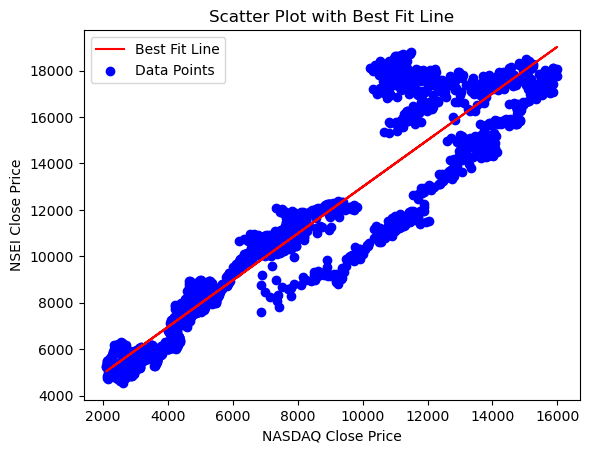

In [14]:
# Creating a scatter plot
plt.scatter(nas, nse, color='blue', label='Data Points')

# Fitting a linear regression model
regression = LinearRegression()
regression.fit(nas.values.reshape(-1, 1), nse.values.reshape(-1, 1))

# Predicting the best fit line
predicted_nsei_close = regression.predict(nas.values.reshape(-1, 1))

# Plotting the best fit line
plt.plot(nas, predicted_nsei_close, color='red', label='Best Fit Line')

# Adding labels and title
plt.xlabel('NASDAQ Close Price')
plt.ylabel('NSEI Close Price')
plt.title('Scatter Plot with Best Fit Line')

# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()

4. **Interpretation of the correlation coefficient (r):**
   1. If r is close to -1 or 1: There is a strong linear relationship between the variables, and the direction of the correlation indicates a negative or positive association, respectively.
   2. If r is close to 0: There is a weak or no linear relationship between the variables.
   3. The closer the absolute value of r is to 1, the stronger the correlation, regardless of the sign.

In [15]:
correlation_coefficient # close to 1 

0.9513138758576782

# Task 2: Lead-Lag Relationship

Plotting the indices' close price:

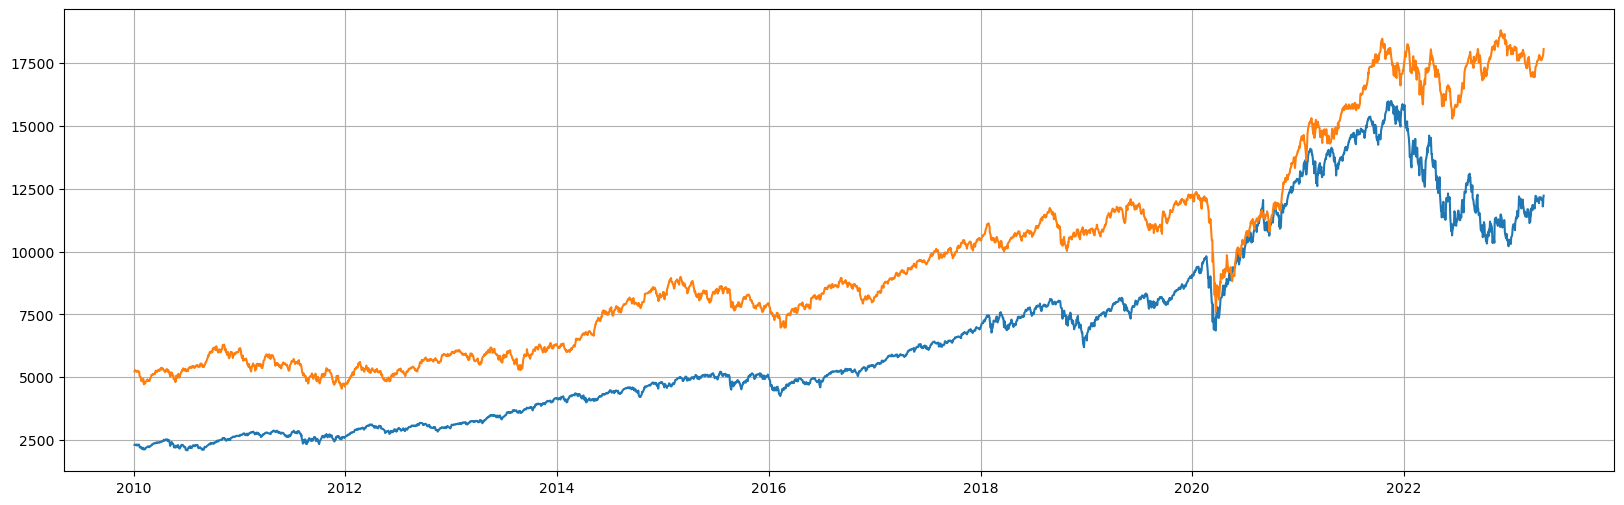

In [20]:
plt.figure(figsize=(20,6))
plt.plot(nas)
plt.plot(nse)
plt.grid(True)
plt.show()

Plotting the returns of indices: 

[]

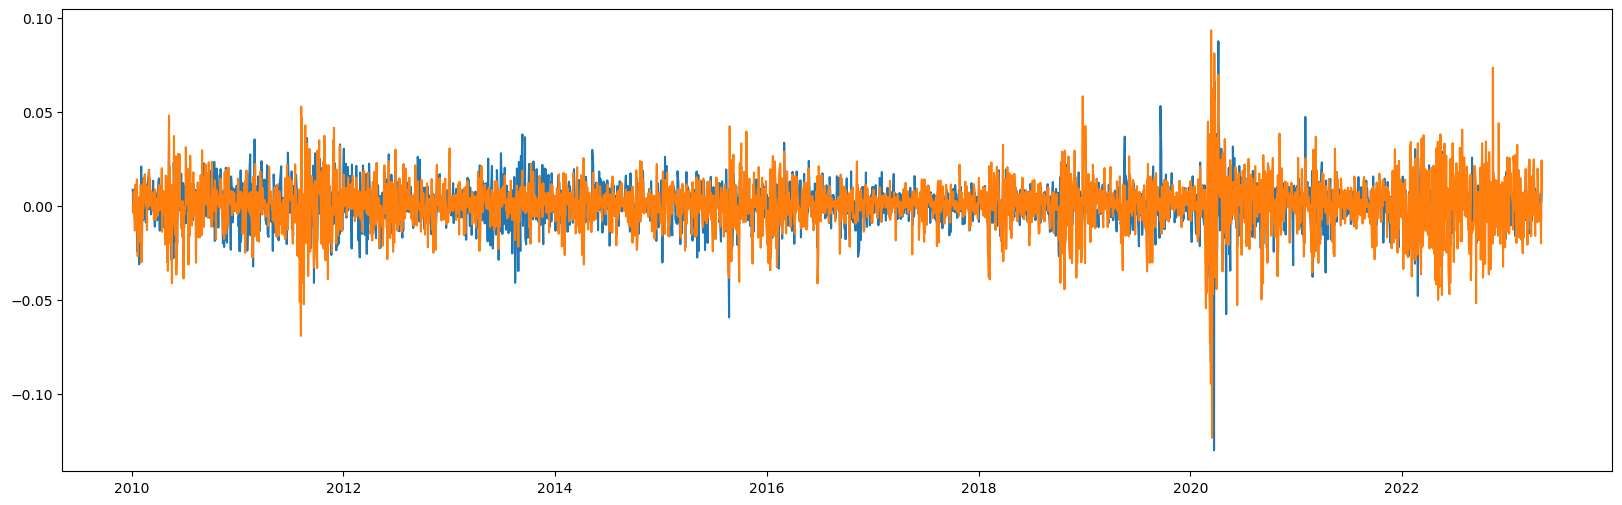

In [22]:
nse_returns = nse.pct_change()
nas_returns = nas.pct_change()
plt.figure(figsize=(20,6))
plt.plot(nse_returns)
plt.plot(nas_returns)
plt.plot()

In [27]:
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

# Lag > 0 --> datax leads datay by lag time periods.
# Lag <0 --> datay leads datax by -lag time periods.

# X = nasdaq, Y = nsei

In [28]:
lags = range(-20, 20)  # Example: consider lags from -30 to +30

In [29]:
crosscorr_values = [crosscorr(nas, nse, lag) for lag in lags]

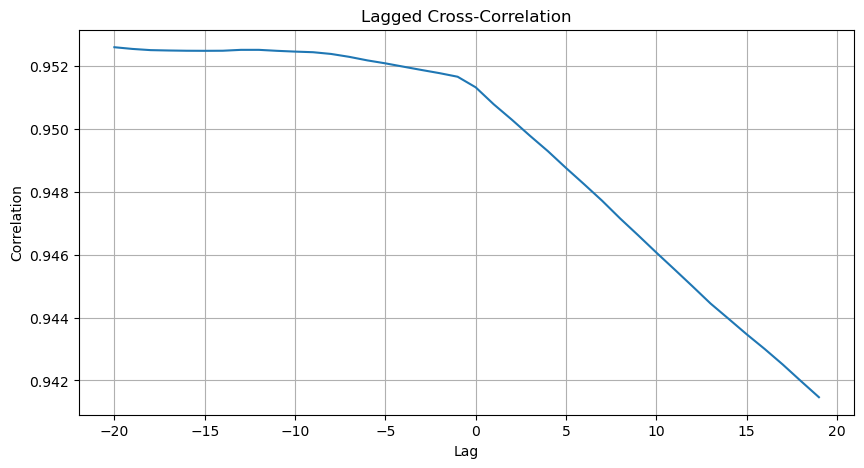

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(lags, crosscorr_values)
plt.title('Lagged Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [33]:
lag = 1 
for lag in range(-20,20):
    nasdaq_lead = np.where(nas > nse.shift(lag), 1, 0).sum()
    nse_lead = np.where(nse.shift(lag) > nas, 1, 0).sum()

    if nasdaq_lead > nse_lead:
        index_for_optimization = '^IXIC'
    else:
        index_for_optimization = '^NSEI'

    print('Index for parameter optimization at lag' , lag , 'is:',index_for_optimization)

Index for parameter optimization at lag -20 is: ^NSEI
Index for parameter optimization at lag -19 is: ^NSEI
Index for parameter optimization at lag -18 is: ^NSEI
Index for parameter optimization at lag -17 is: ^NSEI
Index for parameter optimization at lag -16 is: ^NSEI
Index for parameter optimization at lag -15 is: ^NSEI
Index for parameter optimization at lag -14 is: ^NSEI
Index for parameter optimization at lag -13 is: ^NSEI
Index for parameter optimization at lag -12 is: ^NSEI
Index for parameter optimization at lag -11 is: ^NSEI
Index for parameter optimization at lag -10 is: ^NSEI
Index for parameter optimization at lag -9 is: ^NSEI
Index for parameter optimization at lag -8 is: ^NSEI
Index for parameter optimization at lag -7 is: ^NSEI
Index for parameter optimization at lag -6 is: ^NSEI
Index for parameter optimization at lag -5 is: ^NSEI
Index for parameter optimization at lag -4 is: ^NSEI
Index for parameter optimization at lag -3 is: ^NSEI
Index for parameter optimization at

Highest lagged cross-correlation at lag = 20 means that nsei leads nasdaq by 20 lags. 

Patterns of Leading or Lagging Behavior:

* If the correlation coefficient is positive and the lagged cross-correlation at a positive lag is high, it indicates that one index tends to lead the other with a delay of that specific lag.
* If the correlation coefficient is negative and the lagged cross-correlation at a negative lag is high, it suggests that one index tends to lag behind the other with a delay of that specific lag.
* Analyzing the strength and consistency of the lagged cross-correlation at different lags can help identify the dominant leading or lagging behavior between the two indices.

* The leading index is the one that consistently precedes or provides early signals for price movements. --> NSEI
* The lagging index is the one that tends to follow or react to the movements of the leading index. --> NASDAQ

### 2.4 Provide an explanation for choosing the index for parameter optimization:

The index chosen for parameter optimization should be the leading index. This is because the leading index provides **early signals** or indications of potential price movements, allowing for better parameter optimization. By optimizing the parameters on the leading index, we can potentially generate more accurate trading signals for the lagging index. 

## 3. Indicator Coding:

### 3.1 Keltner Channel Indicator
The Keltner Channel is a technical indicator used to analyse the stock market. It comprises three separate lines used to analyse the price volatility. The middle line is an exponential moving average (EMA) of the price. The above line is set two times the average true range (ATR) above EMA. Similarly, the lower line is set two times the ATR below the EMA.

Most of the time, the price ranges between the high and the low prices. If the price crosses above the upper line or below the lower line, there is a high possibility of a trend reversal.
https://medium.com/codex/algorithmic-trading-with-the-keltner-channel-in-python-9c272051d43d 
https://github.com/justmobiledev/python-algorithmic-trading/blob/main/strategies/Keltner-channel-Breakout.ipynb 
https://analyzingalpha.com/keltner-channels 
https://www.tradingcampus.in/keltner-channel-indicator/ 

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from termcolor import colored as cl
from math import floor

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

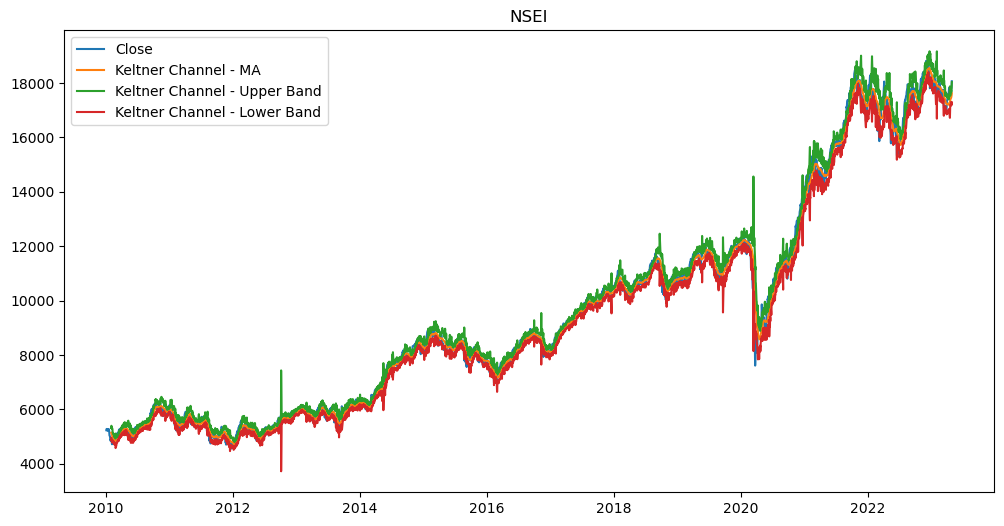

In [36]:
data=yf.download('^NSEI', start='2010-1-1', end='2023-5-1', progress= False)
data['KC_MA'] = data['Close'].rolling(window=20).mean()
data['KC_ATR'] = data['High'] - data['Low']
data['KC_UB'] = data['KC_MA'] + (2 * data['KC_ATR'])
data['KC_LB'] = data['KC_MA'] - (2 * data['KC_ATR'])
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['KC_MA'], label='Keltner Channel - MA')
plt.plot(data['KC_UB'], label='Keltner Channel - Upper Band')
plt.plot(data['KC_LB'], label='Keltner Channel - Lower Band')
plt.title("NSEI")
plt.legend()
plt.show()

# implementation of Keltner

In [37]:
import numpy as np
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

In [38]:
buy_price, sell_price, kc_signal = implement_kc_strategy(data['Close'], data['KC_UB'], data['KC_LB'])
data=data.iloc[:-1,:]

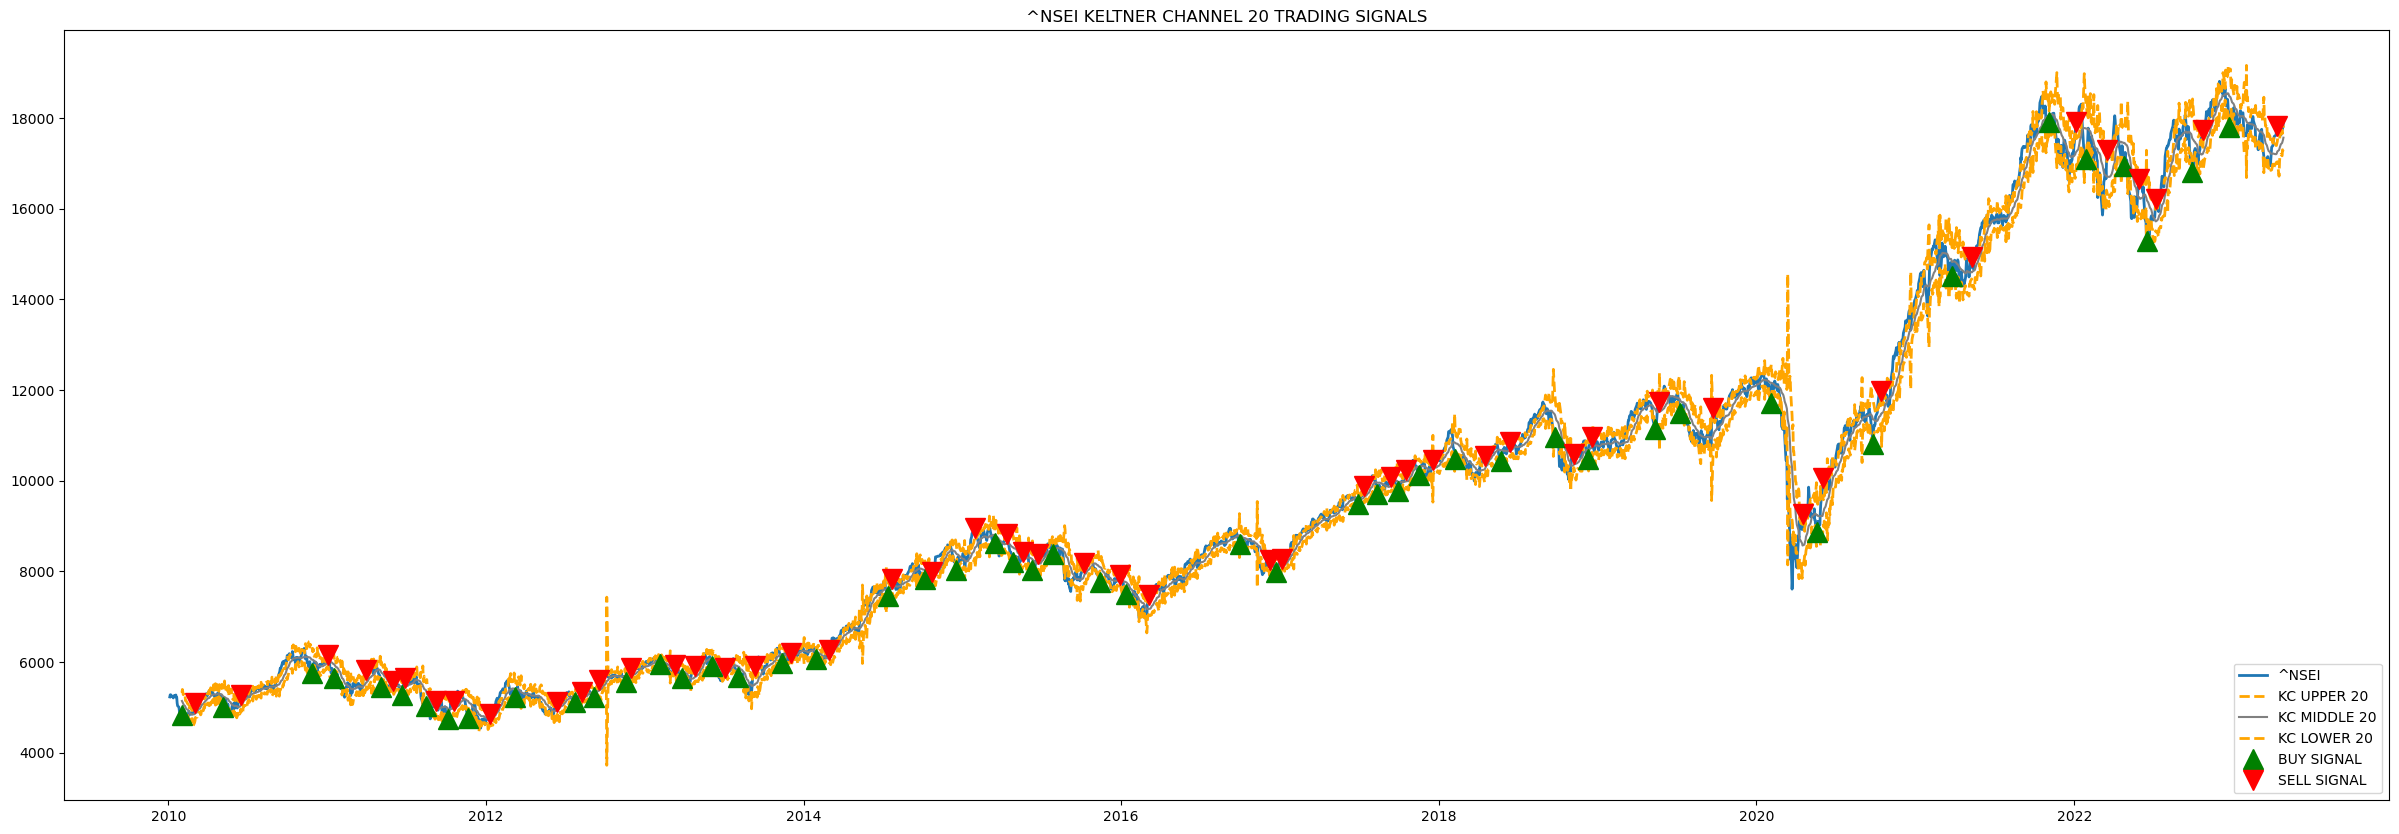

In [39]:
plt.figure(figsize=(30,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['KC_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(data['KC_MA'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(data['KC_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('^NSEI KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [40]:
buy_kc=pd.DataFrame(buy_price)
buy_kc=buy_kc.fillna(0)
buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
sell_kc=pd.DataFrame(sell_price)
sell_kc=sell_kc.fillna(0)
sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]

In [41]:
np1=np.array(buy_kc)
np2=np.array(sell_kc)
(np2-np1).mean(), (np2-np1).std()

(219.43201171875, 500.91326541016883)

In [44]:
buy_kelt=pd.DataFrame(buy_price)
sell_kelt=pd.DataFrame(sell_price)
buy_kelt=buy_kelt.fillna('ffill')
sell_kelt=sell_kelt.fillna('ffill')

Calculating the sharpe ratio:

In [50]:
import math
def sharpe_ratio(data, risk_free_rate=0):
    # Calculate Average  Return
    mean_daily_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_daily_return/sigma)

In [51]:
def sortino_ratio(data):
    mean_return = data.mean()
    std_neg = data[data<0].std()
    return mean_return/std_neg


In [52]:
print("Sharpe Ratio", sharpe_ratio(np2-np1))
print("Sortino Ratio", sortino_ratio(np2-np1))
print("MDD_KC",(np1-np2).min()/np2[18,0]*100,"%")
print("CUMM_Return_KC",((np2-np1)/np1).max()*100,"%")

Sharpe Ratio 0.43806388624799114
Sortino Ratio 0.30309615580830157
MDD_KC -18.837973195892648 %
CUMM_Return_KC 13.317230883005408 %


# Bollinger Bands:

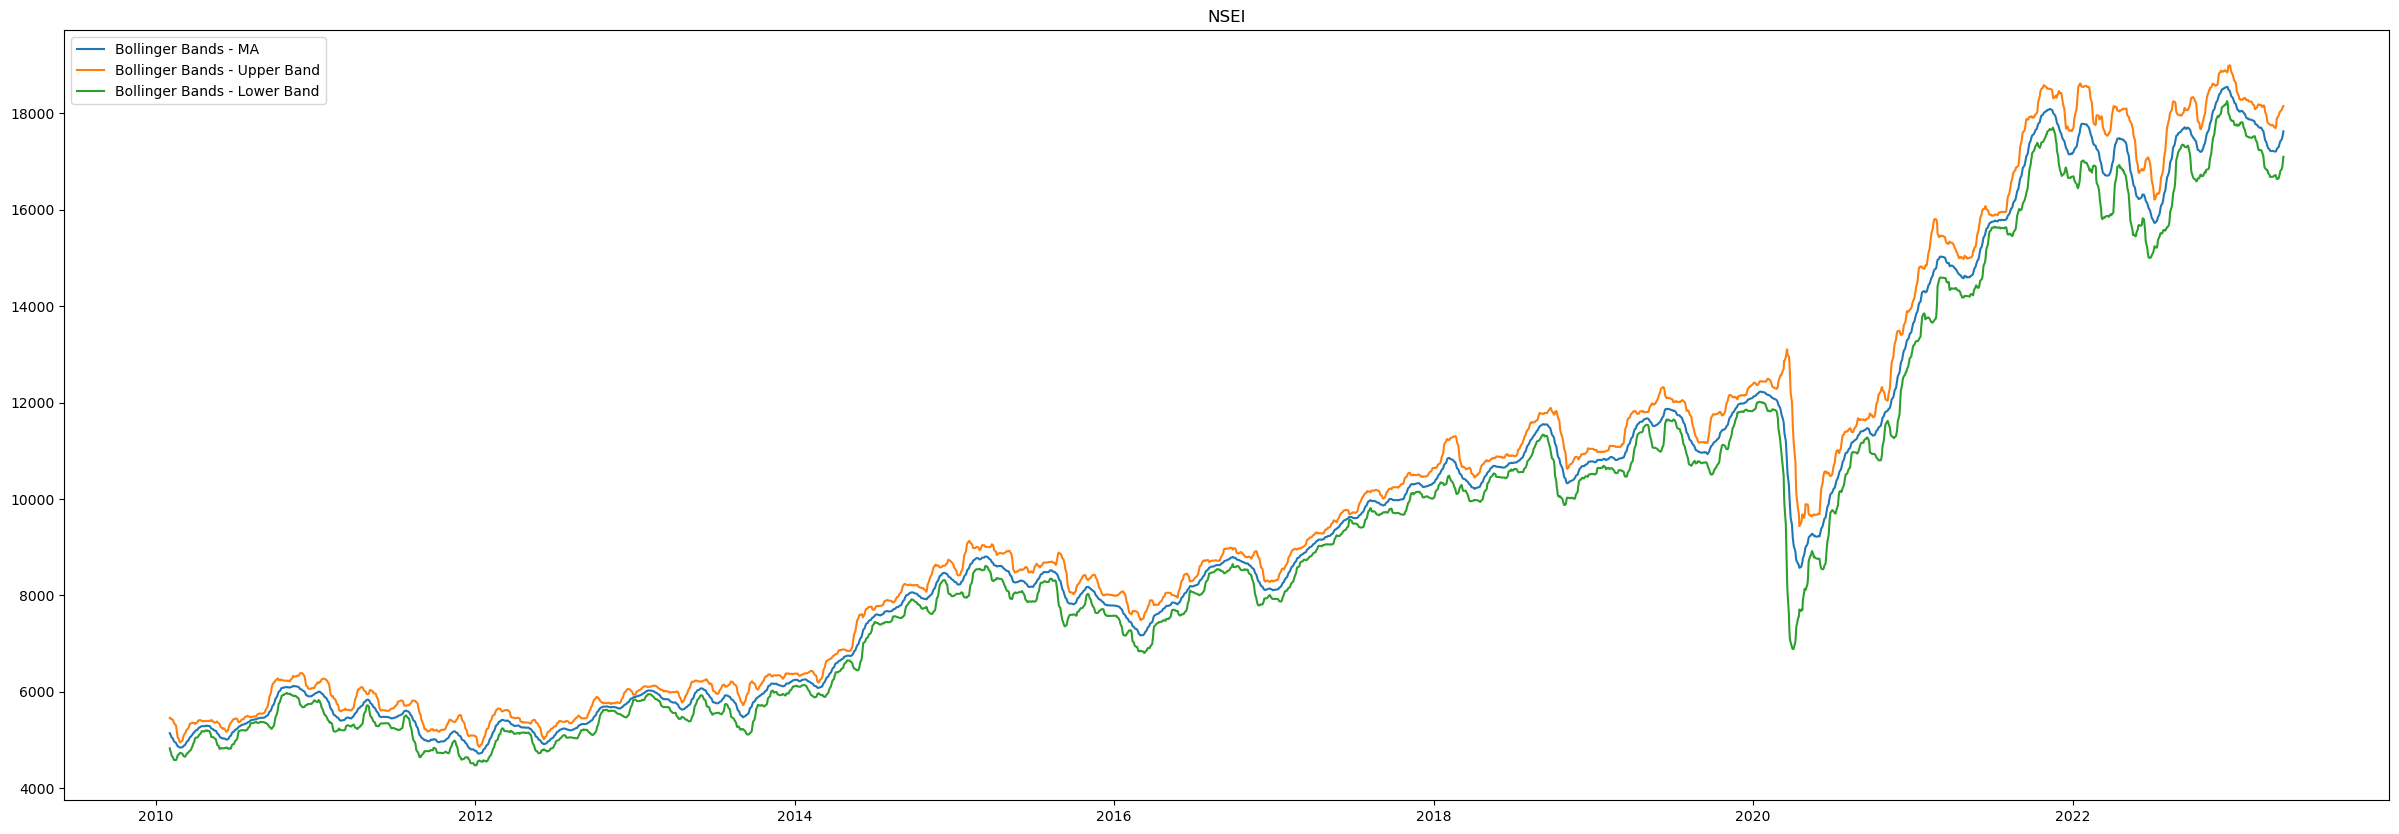

In [53]:
data=yf.download('^NSEI', start='2010-1-1', end='2023-5-1', progress= False)
data['BB_MA'] = data['Close'].rolling(window=20).mean()
data['BB_std'] = data['Close'].rolling(window=20).std()
data['BB_UB'] = data['BB_MA'] + (2 * data['BB_std'])
data['BB_LB'] = data['BB_MA'] - (2 * data['BB_std'])
plt.figure(figsize=(30, 10))
plt.plot(data['BB_MA'], label='Bollinger Bands - MA')
plt.plot(data['BB_UB'], label='Bollinger Bands - Upper Band')
plt.plot(data['BB_LB'], label='Bollinger Bands - Lower Band')
plt.legend(loc='best')
plt.title("NSEI")
plt.show()

In [54]:
#implementing Bollinger bands
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price_bb = []
    sell_price_bb = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price_bb.append(data[i])
                sell_price_bb.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price_bb.append(np.nan)
            sell_price_bb.append(np.nan)
            bb_signal.append(0)
            
    return buy_price_bb, sell_price_bb, bb_signal

In [55]:
buy_price_bb, sell_price_bb, bb_signal = implement_bb_strategy(data['Close'], data['BB_UB'], data['BB_LB'])

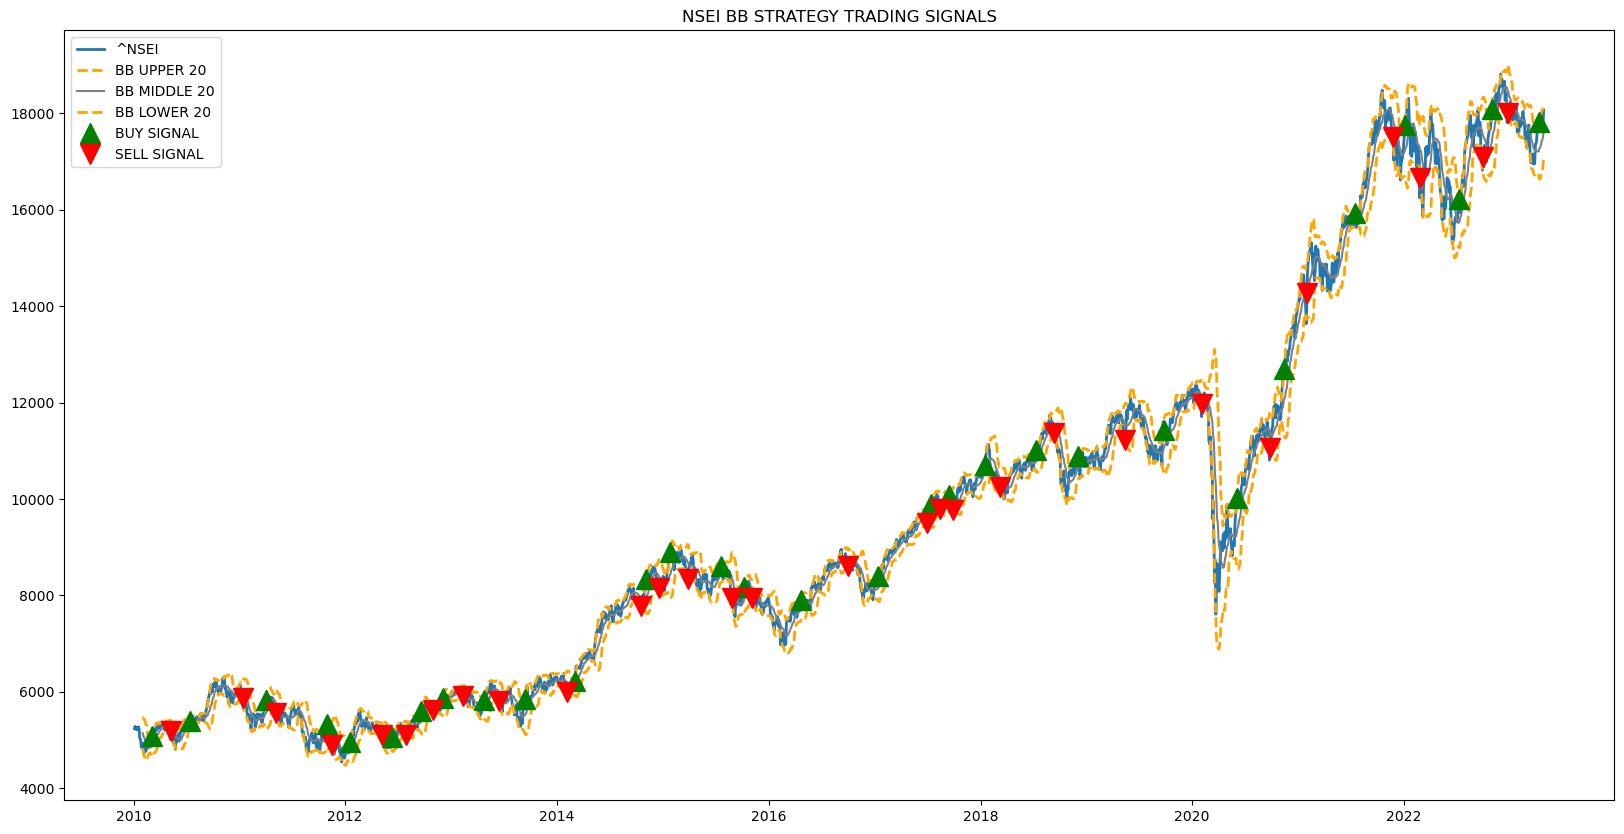

In [56]:
plt.figure(figsize=(20,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['BB_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB UPPER 20')
plt.plot(data['BB_MA'], linewidth = 1.5, color = 'grey', label = 'BB MIDDLE 20')
plt.plot(data['BB_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB LOWER 20')
plt.plot(data.index, buy_price_bb, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price_bb, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('NSEI BB STRATEGY TRADING SIGNALS')
plt.show()

In [57]:
buy_price_bb=pd.DataFrame(buy_price_bb)
buy_price_bb=buy_price_bb.fillna(0)
buy_price_bb=buy_price_bb[~(buy_price_bb == 0).all(axis=1)]
sell_price_bb=pd.DataFrame(sell_price_bb)
sell_price_bb=sell_price_bb.fillna(0)
sell_price_bb=sell_price_bb[~(sell_price_bb == 0).all(axis=1)]
np_buy_bb=np.array(buy_price_bb)
np_buy_bb = np_buy_bb[:-1]
np_sell_bb=np.array(sell_price_bb)
(np_sell_bb-np_buy_bb).mean() , (np_sell_bb-np_buy_bb).std()

(216.96383351293105, 669.5380314208738)

In [58]:
def sharpe_ratio(data, risk_free_rate=0.03):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_return/sigma)

def sortino_ratio(data):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    std_neg = data[data<0].std()
    return mean_return/std_neg

In [59]:
print("Sharpe Ratio", sharpe_ratio(np_sell_bb-np_buy_bb))
print("Sortino Ratio" , sortino_ratio(np_sell_bb-np_buy_bb))
print("MDD_BB",(np_buy_bb-np_sell_bb).min()/np_sell_bb[6,0]*100,"%")
print("CUMM_Return_BB",((np_sell_bb-np_buy_bb)/np_buy_bb).max()*100,"%")

Sharpe Ratio 0.3240500514250054
Sortino Ratio 0.7512898905355797
MDD_BB -28.300449051562993 %
CUMM_Return_BB 25.046411223769834 %


## MACD INDICATOR:

[*********************100%***********************]  1 of 1 completed


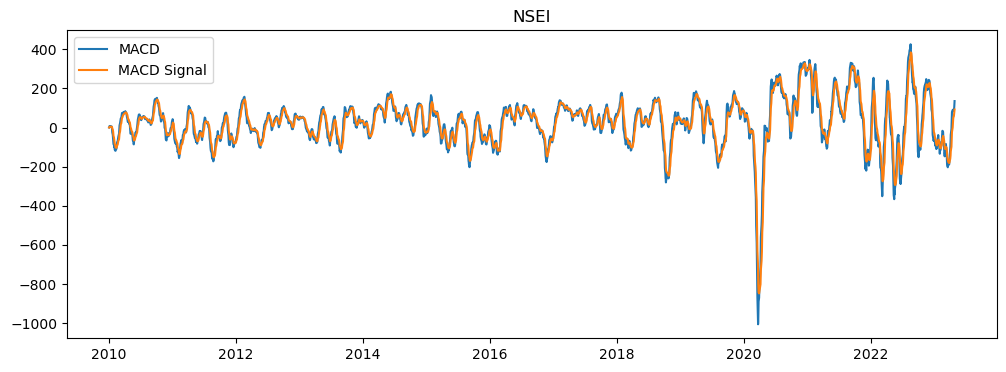

In [60]:
data=yf.download('^NSEI', start='2010-1-1', end='2023-5-1')
data['MACD_12EMA'] = data['Close'].ewm(span=12, adjust=False).mean()
data['MACD_26EMA'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['MACD_12EMA'] - data['MACD_26EMA']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
plt.figure(figsize=(12, 4))
plt.plot(data['MACD'], label='MACD')
plt.plot(data['MACD_Signal'], label='MACD Signal')
plt.legend()
plt.title("NSEI")
plt.show()

In [61]:
def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        if df['MACD'][i] > df['MACD_Signal'][i]:         # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                 # so first flip above means buy
            if flag != 1:                            # after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onward
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACD_Signal'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(data)
data['buy_sig'] = signal[0]
data['sell_sig'] = signal[1]

In [62]:
buy_sig_md=pd.DataFrame(data['buy_sig']).fillna(0)
buy_sig_md

buy_sig_md=buy_sig_md[~(buy_sig_md == 0).all(axis=1)]
buy_sig_md
np_buy_md=np.array(buy_sig_md)

sell_sig_md=pd.DataFrame(data['sell_sig']).fillna(0)
sell_sig_md

sell_sig_md=sell_sig_md[~(sell_sig_md == 0).all(axis=1)]
sell_sig_md
np_sell_md=np.array(sell_sig_md)

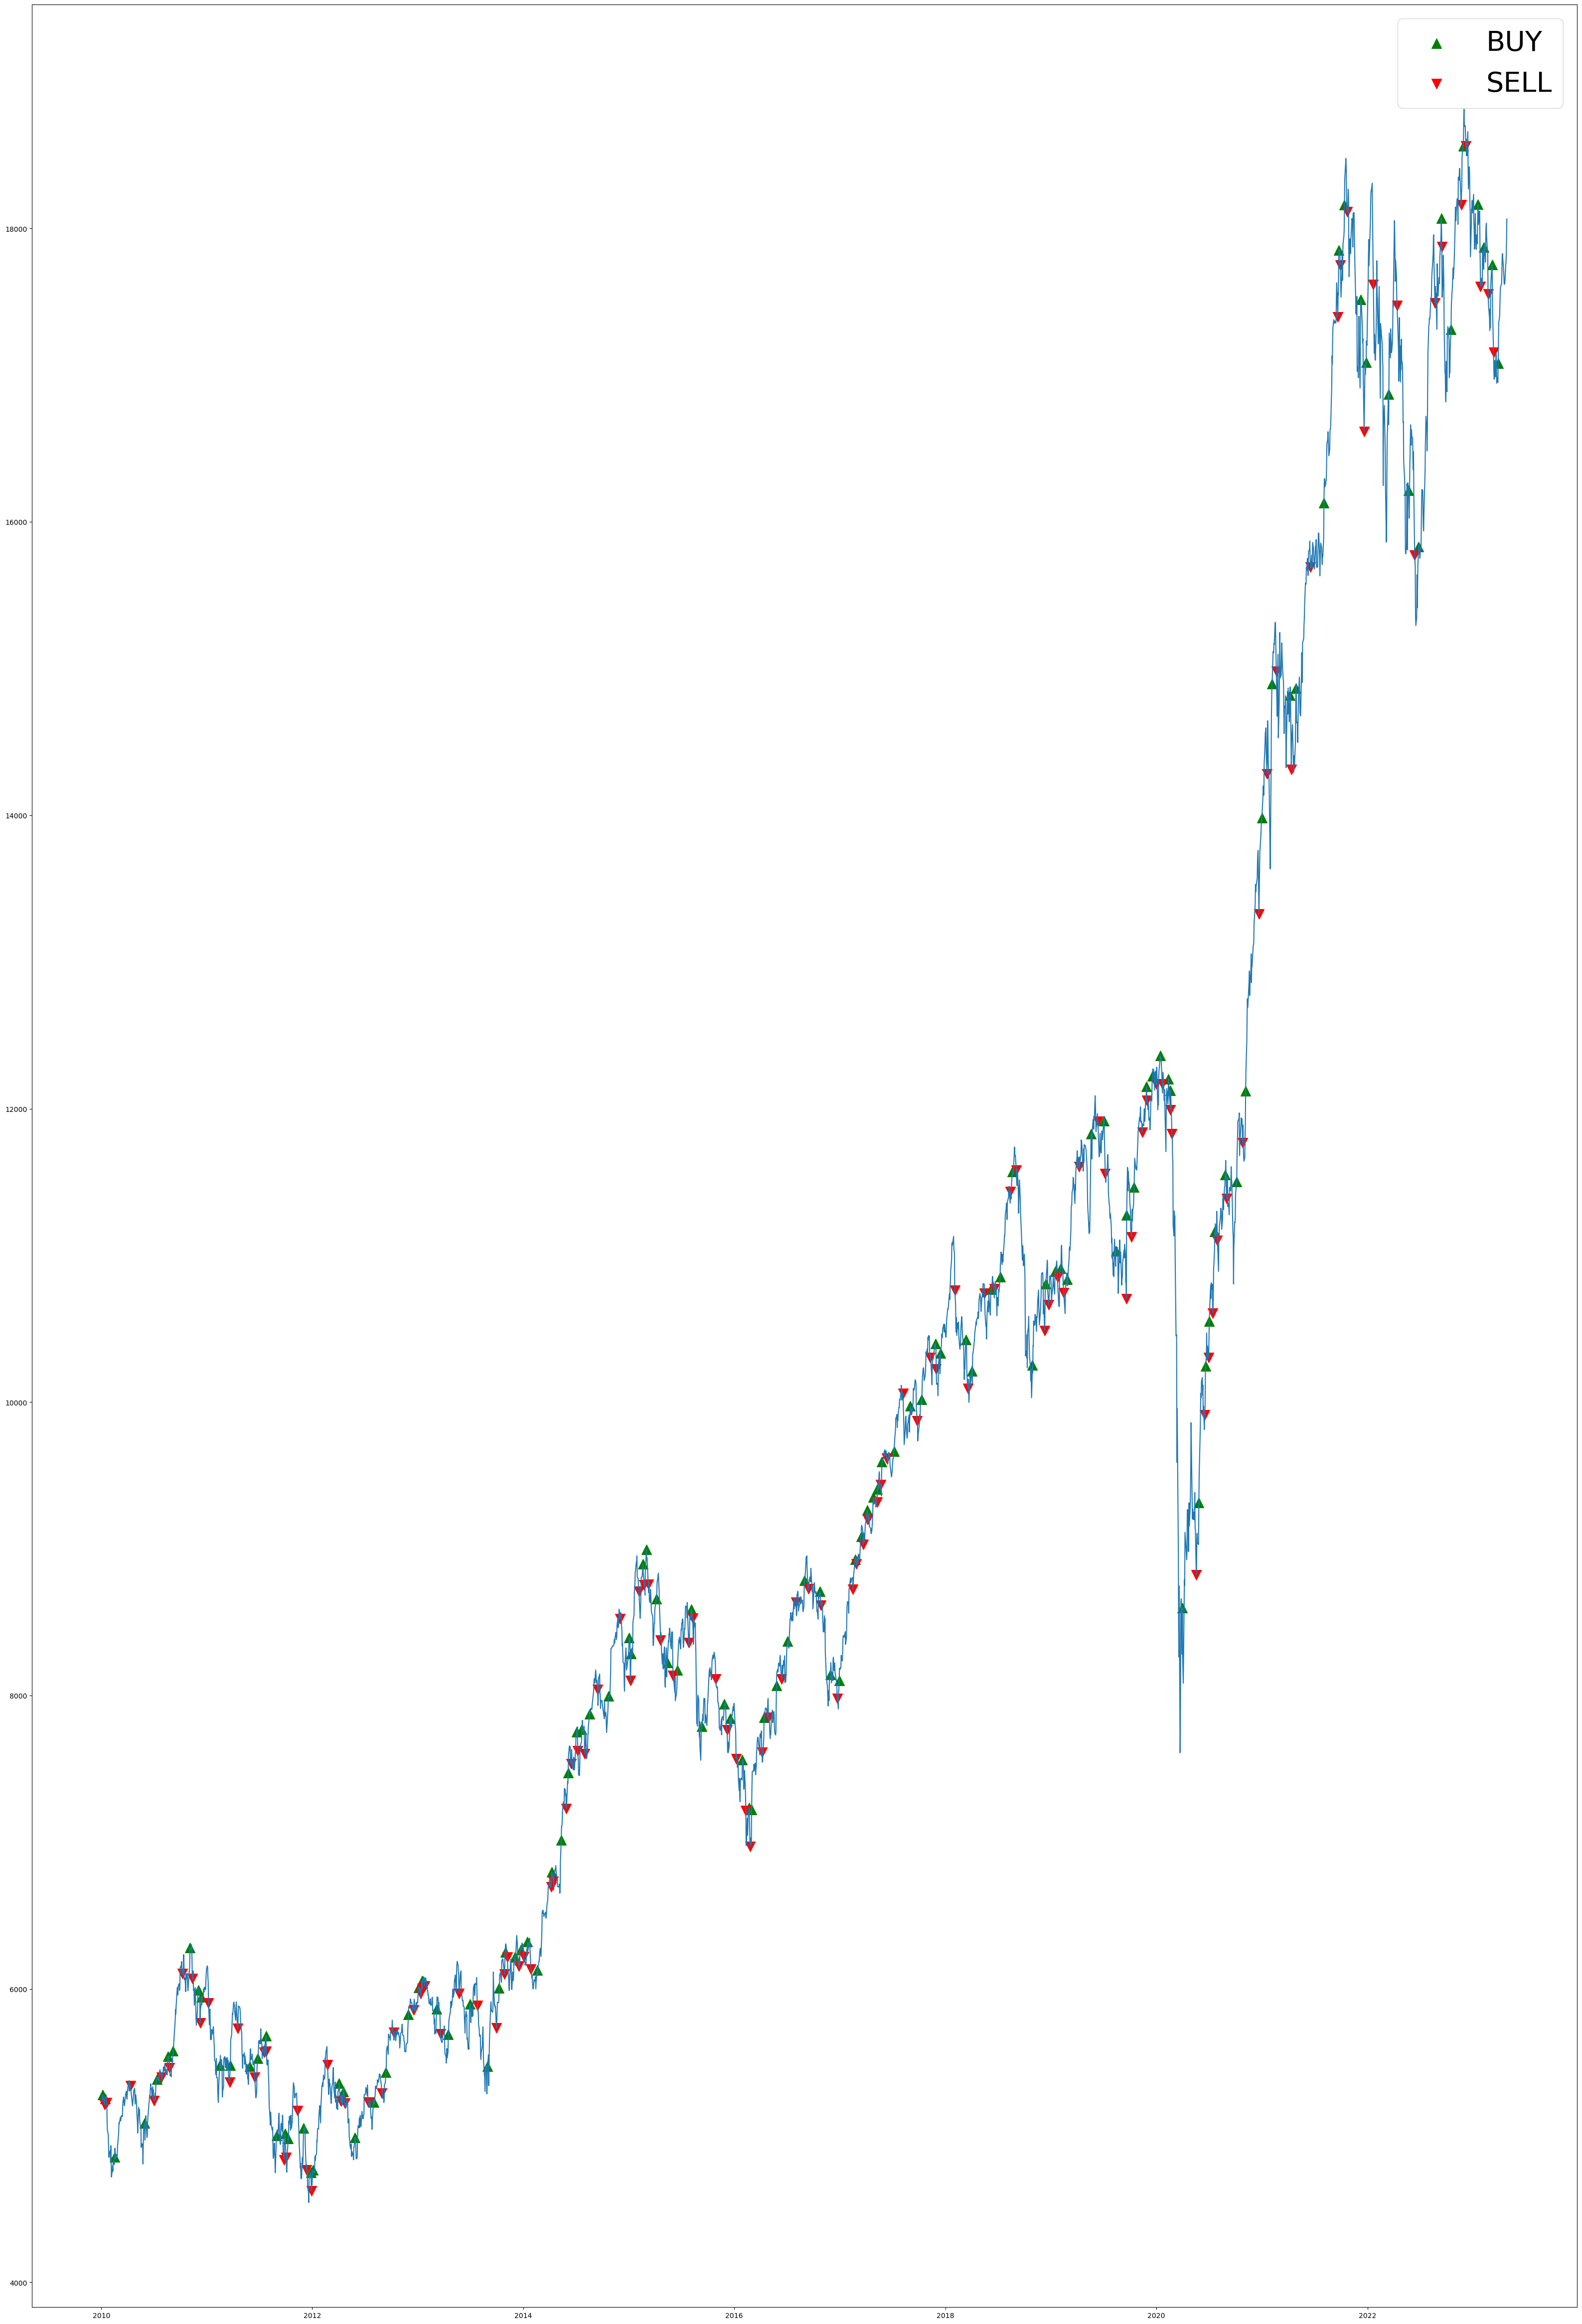

In [64]:
plt.figure(figsize=(40,60))
plt.plot( data['Close'])
plt.scatter(data.index, data.buy_sig, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(data.index, data.sell_sig, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.legend(fontsize="40")
plt.show()

In [65]:
np_buy_md=np_buy_md[:-1]
(np_sell_md-np_buy_md).mean()

60.898765625

In [ ]:
def sharpe_ratio(data, risk_free_rate=0.03):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_return/sigma)

def sortino_ratio(data):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    std_neg = data[data<0].std()
    return mean_return/std_neg


In [66]:
pd.DataFrame(np_buy_md-np_sell_md).idxmin()
print("MDD_MACD",(np_buy_md-np_sell_md).min()/np_sell_md[22,0]*100,"%")
print("CUMM_Return_MACD",((np_sell_md-np_buy_md)/np_buy_md).max()*100,"%")

MDD_MACD -31.758770836202398 %
CUMM_Return_MACD 15.06725766327907 %


In [67]:
sharpe_ratio(np_sell_md-np_buy_md), sortino_ratio(np_sell_md-np_buy_md)

(0.16675361734907584, 0.38904088624809824)

# Keltner Channel

[*********************100%***********************]  1 of 1 completed


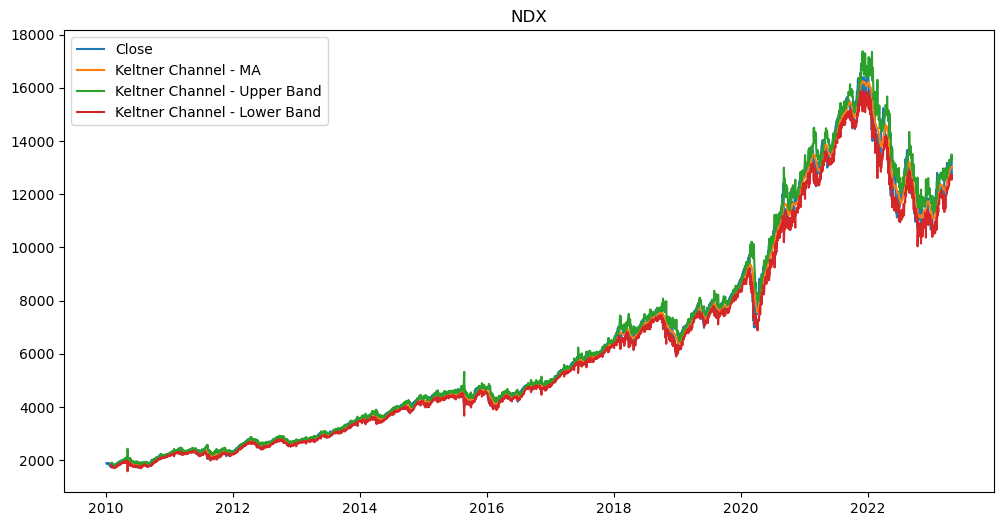

In [68]:
data=yf.download('^NDX', start='2010-1-1', end='2023-5-1')
data['KC_MA'] = data['Close'].rolling(window=20).mean()
data['KC_ATR'] = data['High'] - data['Low']
data['KC_UB'] = data['KC_MA'] + (2 * data['KC_ATR'])
data['KC_LB'] = data['KC_MA'] - (2 * data['KC_ATR'])
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['KC_MA'], label='Keltner Channel - MA')
plt.plot(data['KC_UB'], label='Keltner Channel - Upper Band')
plt.plot(data['KC_LB'], label='Keltner Channel - Lower Band')
plt.title("NDX")
plt.legend()
plt.show()

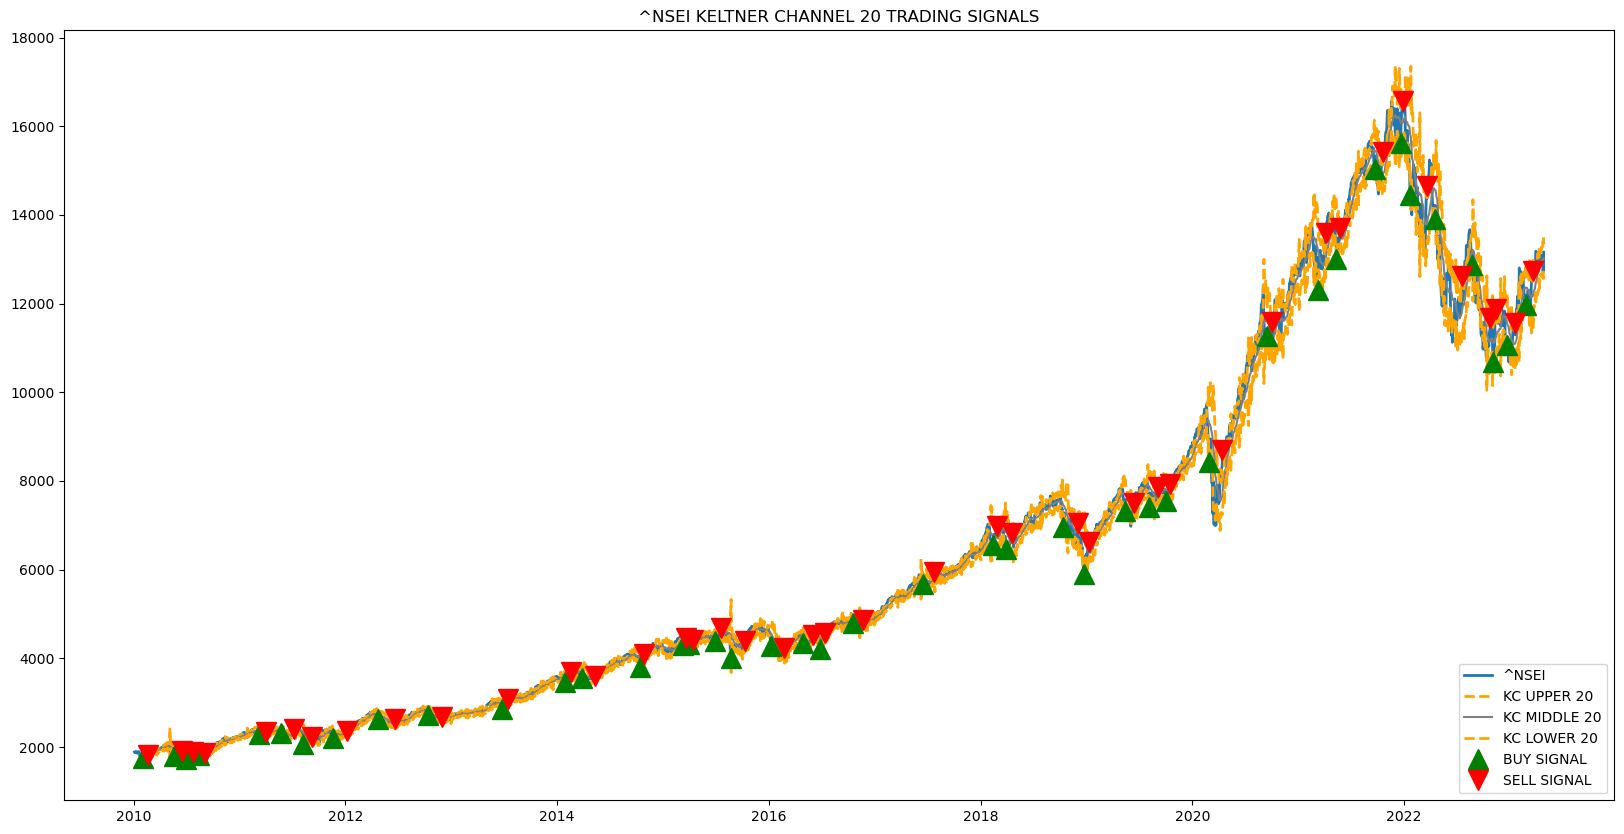

In [69]:
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal
buy_price, sell_price, kc_signal = implement_kc_strategy(data['Close'], data['KC_UB'], data['KC_LB'])
data=data.iloc[:-1,:]

plt.figure(figsize=(20,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['KC_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(data['KC_MA'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(data['KC_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('^NSEI KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [70]:
buy_kc=pd.DataFrame(buy_price)
buy_kc=buy_kc.fillna(0)
buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
sell_kc=pd.DataFrame(sell_price)
sell_kc=sell_kc.fillna(0)
sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]
np1=np.array(buy_kc)
np2=np.array(sell_kc)
(np2-np1).mean()
(np2-np1).std()
buy_kelt=pd.DataFrame(buy_price)
sell_kelt=pd.DataFrame(sell_price)
buy_kelt=buy_kelt.fillna(0)
sell_kelt=sell_kelt.fillna(0)

In [71]:
import math
def sharpe_ratio(data, risk_free_rate=0):
    # Calculate Average  Return
    mean_daily_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_daily_return/sigma)

In [72]:
def sortino_ratio(data):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    std_neg = data[data<0].std()
    return mean_return/std_neg


In [73]:
sharpe_ratio(np2-np1), sortino_ratio(np2-np1)

(0.5345554145045922, 0.3998792079956027)

In [74]:
print("MDD_KC",(np1-np2).min()/np2[18,0]*100,"%")
print("CUMM_Return_KC",((np2-np1)/np1).max()*100,"%")

MDD_KC -30.701894989649354 %
CUMM_Return_KC 12.231683690660775 %


In [78]:
%pip install ta 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29098 sha256=70aa19372b9f6789c064c80ef8b0252240397730a6531b387fb3e58724a74bfc
  Stored in directory: c:\users\mailt\appdata\local\pip\cache\wheels\4c\b6\d3\f919b6ed5638198dd32b8fbea60cee9d074d4825eea2c71db8
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [79]:
from sklearn.model_selection import GridSearchCV
import ta
from sklearn.base import BaseEstimator

In [80]:
# Custom estimator class for Keltner Channel
class KeltnerChannelEstimator(BaseEstimator):
    def __init__(self, window):
        self.window = window

    def fit(self, X, y=None):
        indicator = ta.volatility.KeltnerChannel(X['Close'], X['Low'], X['Close'], window=self.window, fillna=True)
        return self

# Custom estimator class for Bollinger Bands
class BollingerBandsEstimator(BaseEstimator):
    def __init__(self, window):
        self.window = window

    def fit(self, X, y=None):
        indicator = ta.volatility.BollingerBands(X['Close'], window=self.window, fillna=True)
        return self
# Custom estimator class for MACD

class MACDEstimator(BaseEstimator):
    def __init__(self, window_slow, window_fast):
        self.window_slow = window_slow
        self.window_fast = window_fast

    def fit(self, X, y=None):
        indicator = ta.trend.MACD(X['Close'], window_slow=self.window_slow, window_fast=self.window_fast, fillna=True)
        return self


In [84]:

# Define the parameter grid for each indicator
keltner_params = {'window': [10, 20, 30]}
bollinger_params = {'window': [10, 20, 30]}
macd_params = {'window_slow': [26, 30, 34], 'window_fast': [12, 14, 16]}

# Define the scoring metrics for evaluation
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

In [93]:
nas_df=yf.download('^IXIC', start='2010-1-1', end='2023-5-1')
nse_df=yf.download('^NSEI', start='2010-1-1', end='2023-5-1')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [94]:
# Perform grid search for Keltner Channel
keltner_grid = GridSearchCV(estimator=KeltnerChannelEstimator(window=10), param_grid=keltner_params, scoring=scoring, refit=False)
keltner_grid.fit(nas_df)
keltner_results = pd.DataFrame(keltner_grid.cv_results_)

c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mailt\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y_true'


c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan]



In [97]:
# Perform grid search for Bollinger Bands
bollinger_grid = GridSearchCV(estimator=BollingerBandsEstimator(window=10), param_grid=bollinger_params, scoring=scoring, refit=False)
bollinger_grid.fit(nas_df)
bollinger_results = pd.DataFrame(bollinger_grid.cv_results_)

c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mailt\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y_true'


c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan]



In [98]:
# Create an instance of MACDEstimator
macd_estimator = MACDEstimator(window_slow=26, window_fast=12)

macd_grid = GridSearchCV(estimator=macd_estimator, param_grid=macd_params, scoring=scoring, refit=False)
macd_grid.fit(nas_df)
macd_results = pd.DataFrame(macd_grid.cv_results_)

c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mailt\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y_true'


c:\Users\mailt\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]



In [99]:
# Evaluate the grid search results
keltner_best_params = keltner_results.loc[keltner_results['rank_test_accuracy'] == 1, 'params'].values[0]
bollinger_best_params = bollinger_results.loc[bollinger_results['rank_test_accuracy'] == 1, 'params'].values[0]
macd_best_params = macd_results.loc[macd_results['rank_test_accuracy'] == 1, 'params'].values[0]

print("Optimized Parameters:")
print("Keltner Channel:", keltner_best_params)
print("Bollinger Bands:", bollinger_best_params)
print("MACD:", macd_best_params)

Optimized Parameters:
Keltner Channel: {'window': 10}
Bollinger Bands: {'window': 10}
MACD: {'window_fast': 12, 'window_slow': 26}


In [103]:
# Apply the optimized parameters to the indicators
keltner_indicator = ta.volatility.KeltnerChannel(nas_df['Close'], nas_df['Low'], nas_df['Close'], window=keltner_best_params['window'], fillna=True)
bollinger_indicator = ta.volatility.BollingerBands(nas_df['Close'], window=bollinger_best_params['window'], fillna=True)
macd_indicator = ta.trend.MACD(nas_df['Close'], window_slow=macd_best_params['window_slow'], window_fast=macd_best_params['window_fast'], fillna=True)

# Generate buy and sell signals
keltner_signal = np.where(nas_df['Close'] > keltner_indicator.keltner_channel_hband(), 1, 0)  # Buy signal
bollinger_signal = np.where(nas_df['Close'] < bollinger_indicator.bollinger_lband(), -1, 0)  # Sell signal
macd_signal = np.where(macd_indicator.macd() > macd_indicator.macd_signal(), 1, -1)  # Buy and sell signals based on MACD histogram


# Combine the signals
combined_signal = keltner_signal + bollinger_signal + macd_signal

# Record the signals, dates, and calculate returns
signals = pd.DataFrame({
    'Signal': combined_signal
})

# Calculate the returns
signals['Return'] = signals['Signal'].shift(-1) * nas_df['Close'].pct_change()

# Calculate additional metrics
total_trades = len(signals)
positive_trades = len(signals[signals['Return'] > 0])
negative_trades = len(signals[signals['Return'] < 0])
win_rate = positive_trades / total_trades * 100

# Print the signals and metrics
print("Generated Signals:")
print(signals)

print("\nMetrics:")
print("Total Trades:", total_trades)
print("Positive Trades:", positive_trades)
print("Negative Trades:", negative_trades)
print("Win Rate (%):", win_rate)


Generated Signals:
      Signal  Return
0         -1     NaN
1          1     NaN
2         -1     NaN
3         -1     NaN
4          2     NaN
...      ...     ...
3348      -1     NaN
3349      -2     NaN
3350      -1     NaN
3351       0     NaN
3352       0     NaN

[3353 rows x 2 columns]

Metrics:
Total Trades: 3353
Positive Trades: 0
Negative Trades: 0
Win Rate (%): 0.0


In [105]:

# Apply the optimized parameters to the indicators
keltner_indicator = ta.volatility.KeltnerChannel(nse_df['Close'], nse_df['Low'], nse_df['Close'], window=keltner_best_params['window'], fillna=True)
bollinger_indicator = ta.volatility.BollingerBands(nse_df['Close'], window=bollinger_best_params['window'], fillna=True)
macd_indicator = ta.trend.MACD(nse_df['Close'], window_slow=macd_best_params['window_slow'], window_fast=macd_best_params['window_fast'], fillna=True)

# Generate buy and sell signals
keltner_signal = np.where(nse_df['Close'] > keltner_indicator.keltner_channel_hband(), 1, 0)  # Buy signal
bollinger_signal = np.where(nse_df['Close'] < bollinger_indicator.bollinger_lband(), -1, 0)  # Sell signal
macd_signal = np.where(macd_indicator.macd() > macd_indicator.macd_signal(), 1, -1)  # Buy and sell signals based on MACD histogram


# Combine the signals
combined_signal = keltner_signal + bollinger_signal + macd_signal

# Record the signals, dates, and calculate returns
signals = pd.DataFrame({
    # 'Date': nse_df['Date'],
    'Signal': combined_signal
})

# Calculate the returns
signals['Return'] = signals['Signal'].shift(-1) * nse_df['Close'].pct_change()

# Calculate additional metrics
total_trades = len(signals)
positive_trades = len(signals[signals['Return'] > 0])
negative_trades = len(signals[signals['Return'] < 0])
win_rate = positive_trades / total_trades * 100

# Print the signals and metrics
print("Generated Signals:")
print(signals)

print("\nMetrics:")
print("Total Trades:", total_trades)
print("Positive Trades:", positive_trades)
print("Negative Trades:", negative_trades)
print("Win Rate (%):", win_rate)

Generated Signals:
      Signal  Return
0         -1     NaN
1          1     NaN
2          1     NaN
3          1     NaN
4          1     NaN
...      ...     ...
3263       1     NaN
3264       2     NaN
3265       2     NaN
3266       2     NaN
3267       2     NaN

[3268 rows x 2 columns]

Metrics:
Total Trades: 3268
Positive Trades: 0
Negative Trades: 0
Win Rate (%): 0.0
